## Hidden Markov Models - An exploration into the effectiveness of HMMs for location detection

### Introduction of Hidden Markov Models

$x \in X$ for finite $X$, $y \in Y$ for countable $Y$

Define a markov chain $(X_0, X_1, ..., X_t)$ with state space $X$, and random variables $(Y_1, ..., Y_t)$ with state space $Y$, where the distribution of $Y_i$ only depends on $X_i$, so:

$p(x_{0:t},y_{1:t}) = p(x_0)\sum\limits_{i=1}^{t}{p(x_t|x_{t-1})p(y_t|x_t)}$

We observe $(Y_1, ..., Y_t)$, and want to find $X_t|(Y_1,...,Y_t)$

$p(x_{t}|y_{1:t}) \propto p(y_{t}|x_{t})\sum\limits_{x' \in X}{p(x_t|x')p(x'|y_{1:(t-1)})}$

Hence we can define the following dynamic programming method to calculate $p(x_{t}|y_{1:t})$:

$\alpha(x, 1) = p(y_{1}|x)\sum\limits_{x' \in X}{p(x|x')p(x'|y_{1})}$,

$\alpha(x, t) = p(y_{t}|x)\sum\limits_{x' \in X}{p(x|x')\alpha(x', t-1)}$

$p(x_{t}|y_{1:t}) = \dfrac{\alpha(x_t, t)}{\sum\limits_{x_t \in X}{\alpha(x_t, t)}}$

### Model Specification

A particle $\{X_t\}_{t \geq 0}$, performing a random walk on a maze. At every timestep it picks uniformly from adjacent empty tiles to move to. It also has probability $p_{jump}$ to jump to a random tile distributed uniformly on the empty tiles. After each step, recievers at locations $r_1, ..., r_n$ recieve independent poisson counts $Y_t = (Y_{t,1}, ..., Y_{t,n})$ at rates $\lambda(x_t, r_i) = \dfrac{\lambda}{|r_i - x_t|_2^2+1}$ respectively.

So we have:

$X = \mathbb{S} \subset ([0, 2R] \times [0, 2C]) \cap \mathbb{N}^2$ for some $R, C \in \mathbb{N}, Y = \mathbb{N}^n$

$p(X_{t+1} = x_{t+1} | X_{t} = x_{t}) = \dfrac{1 - p_{jump}}{N(x_t)}\mathbb{1}_{|x_{t+1} - x_{t}|_1 = 1} + \dfrac{p_{jump}}{N}$, where $N = |\mathbb{S}|, N(x_t) = \#\{x : |x - x_t|_1 = 1\}$

$p(Y_{t} = y_{t} | X_{t} = x_{t}) = \prod\limits_{i=1}^n{\dfrac{exp(-\lambda(x_t, r_i))\lambda(x_t, r_i)^{y_{t,i}}}{y_{t,i}!}}$

In this model we position the a reciever at each corner and on each edge:

$r = \{(0,0), (0, C), (0, 2C), (R, 2C), (2R, 2C), (2R, C), (2R, 0), (R, 0)\}$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
from hmm import *

# replace with your preferred animation writer
plt.rcParams['animation.writer'] = 'avconv'
plt.rcParams['animation.avconv_path'] = '/usr/local/bin/avconv'

In [2]:
row = 40
col = 40
T = 10000
rate = 200
jump_prob = 0.0125

In [3]:
W = random_walk(row, col, rate, jump_prob)

for _ in range(T):
    W.step()
    
dist = W.predict()
states = W.get_states()
states = np.abs(states - 1.0)

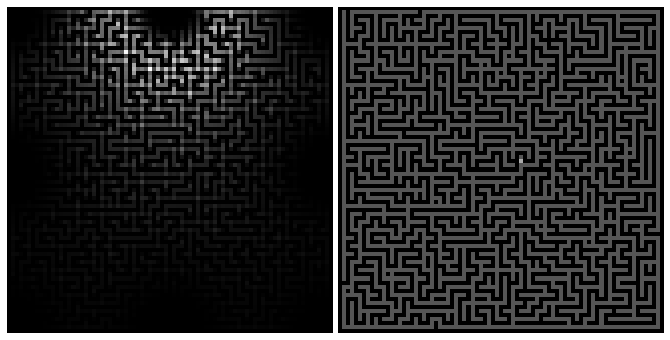

In [16]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(-0.5, 4*col + 2.5), ylim=(-0.5, 2*row + 0.5))
ax.axis('off')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
im = plt.imshow(np.concatenate([dist[0,:,:]/dist[0,:,:].max(), np.ones((2*row+1, 1)), states[0,:,:]/3], axis=1),interpolation='none', cmap=plt.cm.binary_r)

# initialization function: plot the background of each frame
def init():
    im.set_data(np.concatenate([dist[0,:,:]/dist[0,:,:].max(), np.ones((2*row+1, 1)), states[0,:,:]/3], axis=1))
    return [im]

# animation function.  This is called sequentially
def animate(i):
    im.set_array(np.concatenate([dist[i,:,:]/dist[i,:,:].max(), np.ones((2*row+1, 1)), states[i,:,:]/3], axis=1))
    return [im]

# compliles animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T, interval=80, blit=True)

In [17]:
# generates video from animation. Shows location of particle, and heatmap of predicted location
HTML(anim.to_html5_video())

In [19]:
new_performance = np.cumsum([0] + accuracy(W, predict_loc(W, dist)))
old_performance = np.cumsum([0] + accuracy(W, W.mle()))

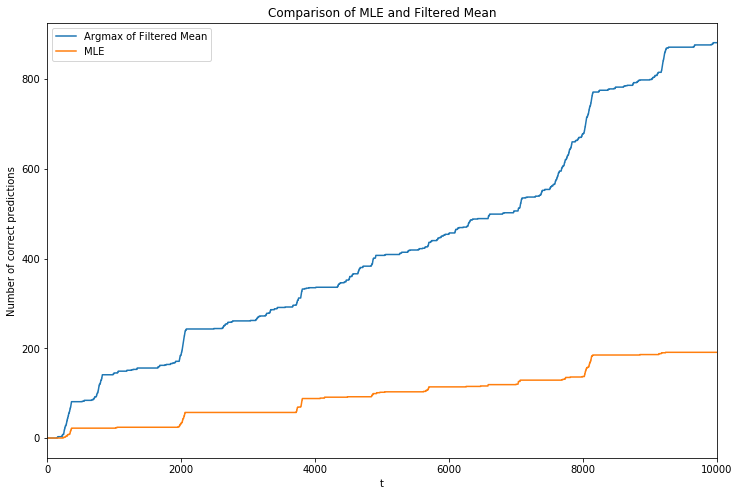

In [20]:
plt.figure(figsize=(12,8))
plt.plot(new_performance)
plt.plot(old_performance)
plt.title('Comparison of MLE and Filtered Mean')
plt.xlabel('t')
plt.ylabel('Number of correct predictions')
plt.legend(['Argmax of Filtered Mean', 'MLE'])
plt.xlim([0, T])
plt.show()

In [21]:
print("Accuracy of Filtered Mean Location Estimation: {:.1f}%".format(100 * new_performance[-1]/T))
print("Accuracy of MLE Location Estimation: {:.1f}%".format(100 * old_performance[-1]/T))

Accuracy of Filtered Mean Location Estimation: 8.8%
Accuracy of MLE Location Estimation: 1.9%
